In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from dotenv import load_dotenv
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
module_path = f"{project_root}/"
sys.path.insert(0, module_path)


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import roc_curve
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing


from utils import *
from classes import *

sns.set_palette(sns.color_palette("deep"))
pl.seed_everything(42, workers=True)

from tqdm import  tqdm

Global seed set to 42


In [3]:
benign_root = f"{project_root}/datasets/final_datasets/benign/full_size"
adv_root = f"{project_root}/datasets/final_datasets/adversarial"

nvp_load_root = f"{project_root}/weights/NVP/dual-transform"


In [4]:
dataset_batch_size=32

## Shuffles the datasets.
should_shuffle_datasets = True



## Needs to be scaled to support resnets dense layers, which require 224,224 image sizes
img_transforms = transforms.Compose([
    transforms.Lambda(lambda x:  F.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False, antialias=True).squeeze(0)),
    ])

## Returns an array and map of the classification labels, i.e. "inanimate".
int_labels, label_map = get_label_arr_and_map(
    torch_features=3
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
mixed_data = gen_mixed_detection_tvt_dict(
        ben_root=benign_root,
        adv_root=adv_root,
        img_transforms=img_transforms,
        batch_size=dataset_batch_size,
        should_shuffle_datasets=True,
        should_truncate_datasets=True,
        should_return_class=True,
        should_return_attack_type=True,
        num_workers=multiprocessing.cpu_count()
    )

In [6]:

def gen_nvp_detectors(nvp_roots):
    detector_list = [[[] for _ in range(4)] for _ in range(4)]
    for i in range(4):
        for j in range(4):
            if i != j:
                weight_load_str = f"{nvp_roots}/{i}-{j}/100/0.0001/trained.pt"
                dualtransform_detector = NVPResnetClassifierDualtransform(
                batch_size=dataset_batch_size,
                custom_channel_value=6,
                optimizer="adam",
                train_dataloader=mixed_data.train,
                val_dataloader=mixed_data.val,
                test_dataloader=mixed_data.test,
                use_transform=(i,j)
                )
                weights = torch.load(weight_load_str)
                dualtransform_detector.load_state_dict(weights)
                dualtransform_detector.eval()
                if torch.cuda.is_available():
                    dualtransform_detector = dualtransform_detector.cuda()
                dualtransform_detector.to("cuda")
                detector_list[i][j] = dualtransform_detector
    return detector_list
def calculate_best_standalone_threshold(preds):
    fpr, tpr, thresholds = roc_curve([x[1] for x in preds],[x[0] for x in preds])
    return thresholds[np.argmax(tpr - fpr)]

In [7]:
detector_list= gen_nvp_detectors(
    nvp_roots=nvp_load_root
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
nvp_functions = {
    "jpg_minpool_jpg": transforms.Compose([JPEGCompressionTransform(),MaxPoolTransform(), JPEGCompressionTransform()]),
    "maxpool": MaxPoolTransform(),
    "minpool": MinPoolTransform(),
    "minpool_jpg" : transforms.Compose([MaxPoolTransform(), JPEGCompressionTransform()]),
    }   

In [9]:
nvp_preds = [[[] for _ in range(4)] for _ in range(4)]


with torch.no_grad():
    for x, y, classes,attack_types in tqdm(mixed_data.test, position=0,leave=True):
            x, y = x.to(device), y.to(device)
            
            transformed_imgs = []
            for i, (nvp_root,nvp_func) in enumerate(nvp_functions.items(),start=0):
                nvp_imgs = nvp_func(x).to(device)
                transformed_imgs.append(nvp_imgs)
            
            for i in range(4):
                first_transformed_images = transformed_imgs[i]
                for j in range(4):
                    if i != j:
                        second_transformed_images = transformed_imgs[j]
                        merged_images = torch.concat((first_transformed_images,second_transformed_images),dim=1)
                        detector = detector_list[i][j]
                        preds = detector(merged_images)
                        for pred, gt, classification, attack in zip(preds, y, classes, attack_types):
                            classification_label = int_labels[classification.item()]
                            nvp_preds[i][j].append((pred.item(),gt.item(),classification_label,attack.item()))

100%|██████████| 769/769 [13:29<00:00,  1.05s/it]


In [10]:


report_list = [[gen_easydict() for i in range(4)] for j in range(4)]

for k in range(4):
    report_list[k][k] = None

for i in range(4):
    for j in range(4):
        if i != j:
            preds = nvp_preds[i][j]
            nvp_threshold = calculate_best_standalone_threshold(preds)
            for pred in preds:
                write_to_easydict(
                            easydict=report_list[i][j],
                            prediction=int((pred[0]>nvp_threshold)),
                            ground_truth=pred[1],
                            classification=pred[2],
                            float_prediction=pred[0]
                        )



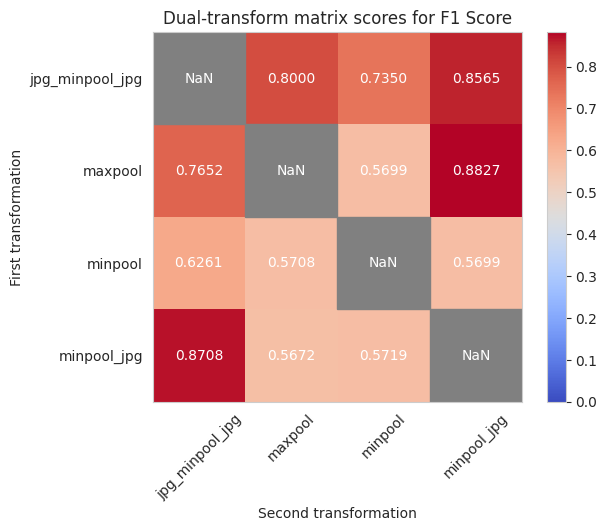

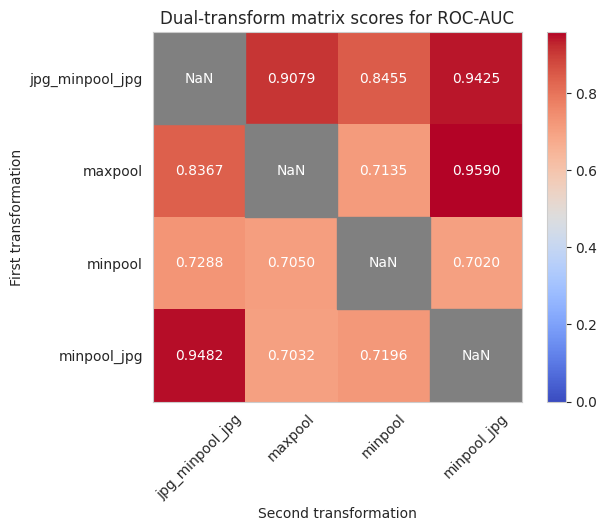

In [11]:
def set_matshow_cell_color(ax, i, j, color):
    ax.add_patch(plt.Rectangle((i - 0.5, j - 0.5), 1, 1, color=color))


sns.set_style("whitegrid", {'axes.grid' : False})
def generate_dualtransform_matrix(metric,metric_str, should_save=False):
    labels = list(nvp_functions.keys())
    fig, ax = plt.subplots()
    f1_score_array = np.array([[calculate_metrics(x)["combined"][metric] if x is not None else 0 for x in inner_list] for inner_list in report_list])
    ax.set_xticks(range(len(labels)), labels, rotation=45)
    ax.set_yticks(range(len(labels)), labels)
    im = ax.imshow(f1_score_array, interpolation='none', cmap=sns.color_palette("coolwarm", as_cmap=True))
    
    plt.colorbar(im)
    set_matshow_cell_color(ax, 0, 0, 'grey')
    set_matshow_cell_color(ax, 1, 1, 'grey')
    set_matshow_cell_color(ax, 2, 2, 'grey')
    set_matshow_cell_color(ax, 3, 3, 'grey')

    for i in range(f1_score_array.shape[0]):
        for j in range(f1_score_array.shape[1]):
            
            plot_text = f"{f1_score_array[i, j]:.4f}" if f1_score_array[i, j] != 0.0 else "NaN"

            # Plt.text must be in the format of "j, i" instead of "i,j" 
            # as the "plt.text" argument takes the first argument "x" as the column index and then the second argument "y" as the row index.
            # In the array, the i is the row index and j is the column index, thus needing them to be switched around.
            ax.text(j, i, plot_text, ha='center', va='center', color='w')
    ax.set_title(f"Dual-transform matrix scores for {metric_str}")
    ax.set_ylabel("First transformation")
    ax.set_xlabel("Second transformation")
    if should_save:
        plt.savefig(f"{project_root}/plots/dualtransform_{metric}.png", bbox_inches = 'tight')
        plt.savefig(f"{project_root}/plots/dualtransform_{metric}.svg", bbox_inches = 'tight')
    plt.show()
generate_dualtransform_matrix("f1_score","F1 Score", should_save=True)
generate_dualtransform_matrix("roc_auc", "ROC-AUC", should_save=True)


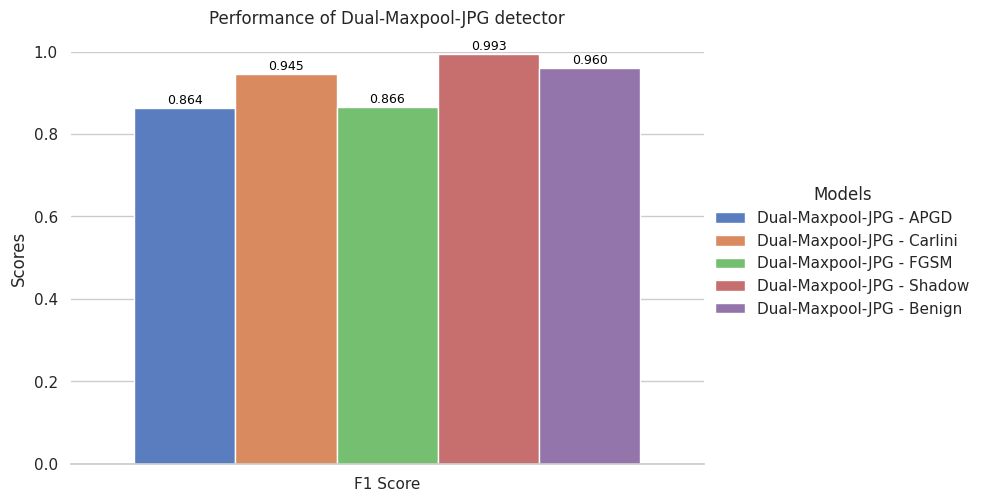

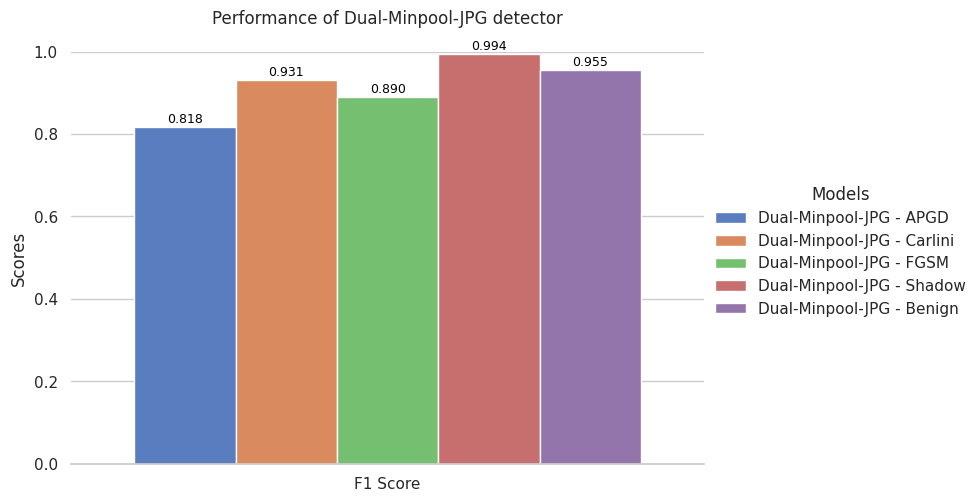

In [12]:


def calculate_pred_list_metrics(predictions, threshold):
    metrics = {}
    attack_types = ['APGD', 'Carlini', 'FGSM', 'Shadow', 'Benign']
    
    def init_attack_dict():
        return {'true_positives': 0, 'false_positives': 0, 'false_negatives': 0, 'true_negatives': 0}

    dictionary = {attack_type: init_attack_dict() for attack_type in attack_types}
    
    for pred_float, ground_truth, _, attack_type in predictions:
        
        pred_label = int(pred_float >= threshold)
        attack_type_str = attack_types[attack_type]
        
        if pred_label == ground_truth:
            if pred_label == 1:
                dictionary[attack_type_str]['true_positives'] += 1
            else:
                dictionary[attack_type_str]['true_negatives'] += 1
        else:
            if pred_label == 1:
                dictionary[attack_type_str]['false_positives'] += 1
            else:
                dictionary[attack_type_str]['false_negatives'] += 1
        


    for key in attack_types:
        data = dictionary[key]
        ## need to flip this, as true negatives are now true positives when dealing with benign images.
        if key == "Benign":
            true_positives = data['true_negatives']
            true_negatives = data['true_positives']
        else:
            true_positives = data['true_positives']
            true_negatives = data['true_negatives']
        false_positives = data['false_positives']
        false_negatives = data['false_negatives']
        

        epsilon = 1e-12
        precision = true_positives / (true_positives + false_positives + epsilon)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        f1_score = 2 * ((precision * recall) / (precision + recall + epsilon))
        fpr = false_positives / (false_positives + true_negatives + epsilon)
        fnr = false_negatives / (true_positives + false_negatives + epsilon)

        metrics[key] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'fpr': fpr,
            'fnr': fnr,
            }

    return metrics

def plot_metrics_nvp_list_metrics(metrics_combined, Bar_str, should_save=False):
    bar_labels = [Bar_str]
    
    merged_metrics = [metrics_combined]

    data = []
    for metric_key in merged_metrics[0].keys():
        for i, d in enumerate(merged_metrics):
            f1_score = d[metric_key]['f1_score']
            data.append({'Models': f'{bar_labels[i]} - {metric_key}', 'Metric': 'F1 Score', 'Value': f1_score})

    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    g = sns.catplot(x="Metric", y="Value", hue="Models", data=df, kind="bar", palette="muted", height=5, aspect=1.5)
    g.despine(left=True)
    g.set_ylabels("Scores")
    plt.title(f'Performance of {Bar_str} detector', pad=20)
    g.set_xlabels("")

    g.axes.flat[0].set_ylim([0.0,1])

    for ax in g.axes.flat:
        for label in ax.containers:
            for p, rect in zip(label.patches, label.get_children()):
                ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 3), textcoords='offset points')
    if should_save:
        plt.savefig(
            f"{project_root}/plots/nvp_attack_type_performance_{Bar_str}_f1.svg",  bbox_inches = 'tight'
        )
        plt.savefig(
            f"{project_root}/plots/nvp_attack_type_performance_{Bar_str}_f1.png",  bbox_inches = 'tight'
        )
    plt.show()

nvp_metrics_1 = calculate_pred_list_metrics(nvp_preds[1][3], calculate_best_standalone_threshold(nvp_preds[1][3]))
nvp_metrics_2 = calculate_pred_list_metrics(nvp_preds[3][0], calculate_best_standalone_threshold(nvp_preds[3][0]))
plot_metrics_nvp_list_metrics(nvp_metrics_1,"Dual-Maxpool-JPG", should_save=True)
plot_metrics_nvp_list_metrics(nvp_metrics_2,"Dual-Minpool-JPG", should_save=True)